# Simulating the drift diffusion model with stochastic differential equation

We will use the stochastic differential equation to simulate the driftdiffusion model. For details see Tuerlinckx et al. (2001).

$$ \Delta L(t) = L(t+h) - L(t) = x(t+h) = \delta * h + \sqrt h * \epsilon (t+h)$$

Import libraries 

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import sys
sys.executable

'/opt/homebrew/Cellar/jupyterlab/3.4.8/libexec/bin/python3.10'

We need to specify the parameters

In [12]:
h = .01 # the time step
delta = .5 # the drift rate
sigma =1 # the drift coefficient
alpha = 2 # threshold separation...assuming bottom threshold is at 0
beta = .5 # relative startpoint
z = beta*alpha # set the start point based on threshold separation 

In [16]:
i = 0
L = [z] #the accumulated evidence starting from the start point

while L[i] >= 0 and L[i] <= alpha:
    
    i = i+1;
    randomNorm = np.random.randn() # draw from std normal distribution
    evidence = delta*h+(sigma*h**(.5))*randomNorm
    L.append(L[i-1] + evidence) # accumulating evidence


the decision time


In [17]:
decisionTime = i*h

the choice True = Yes; False = No


In [18]:
choice = L[i]>=alpha
print(choice)

True


plot a trajectory


In [19]:
theTime = [i for i in np.arange(0*h,(i+1)*h,h)] # note that arange(start, stop, step),stop is not included in list

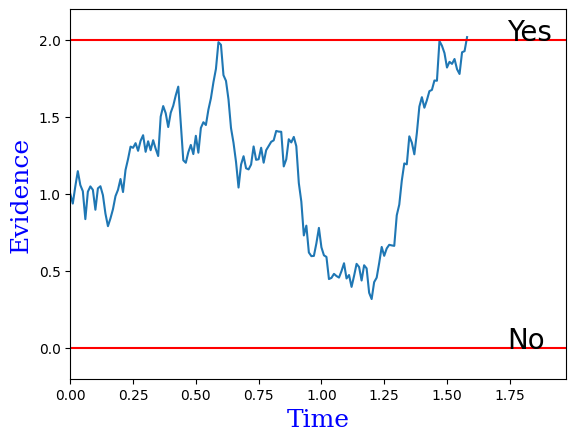

In [20]:
plt.plot(theTime, L)
plt.axhline(y=0, color='r', linestyle='-') # bottom threshold
plt.axhline(y=2, color='r', linestyle='-') # upper threshold
plt.xlim([0,1.25*decisionTime])
plt.ylim([-.20,alpha+.20])
plt.text(1.1*decisionTime,alpha,'Yes', fontsize=20)
plt.text(1.1*decisionTime,0,'No', fontsize=20)

font = {'family':'serif','color':'blue','size':18}
plt.xlabel('Time',fontdict= font)
plt.ylabel('Evidence',fontdict= font)
plt.show()

Note one issue with this simulation approach is that in the final step,
the accumulated evidence ALWAYS overshoots the boundary, and this leads
to inaccuracies in its approximations of the theoretical diffusion
process see Luce (1986) and smith (1990). Heath and Kelly (1988) have an
ad hoc method for correcting by widening the boundaries just a bit. So
that 

$$\alpha \to \alpha + \zeta \sigma \sqrt h $$

$$  0 \to - \zeta \sigma \sqrt h $$

we can get $$ \zeta $$

## Simulate a large number of runs

In [29]:
nd = 500 # number of simulated random walks
reallylargenumber = int(7/(h*delta/sigma))  # to make sure all the simulated random walks will reach a threshold 
                                            #we make sure we generate enough randomnumbers
giantRY = np.random.randn(nd, reallylargenumber) # to generate the evidence samples 
                                                # we will generate a matrix of nd x reallylargenumber
y = delta*h+(sigma*h**.5)*giantRY # this matrix represents the random samples of evidence 
                                    #at each time point that we will accumulate to simulate 
                                    #the drift diffusion process
y = np.concatenate((np.zeros((nd,1))+z, y),axis=1) # add a start point as the first element in each row
L = np.cumsum(y, axis=1) # accumulate (cumulative sum) the information 
                         #across the columns (axis =1) to reprsent Accumulated evidence 
print(giantRY.shape)

(500, 1400)


In [30]:
# get all the row and column indexes for the accumulated evidene that exceeds the thresholds.
exceeds_index = np.argwhere((L>=alpha) | (L<=0) )

In [32]:
# finds all the unique row indices where somewhere the accumulated evidence exceeded the boundary
ur = list(set(exceeds_index[:,0]))

In [33]:
if len(ur) < nd:
    print(nd - len(ur), "simulated random walks did not reach a boundary")
else:
    print("all simulated random walks reached a boundary")

all simulated random walks reached a boundary


In [35]:
# get the index of the first element that hits the boundary for each simulated walk
first_exceed = [exceeds_index[0].tolist()]
for i in range(1, exceeds_index.shape[0]):
    if exceeds_index[i,0] != exceeds_index[i-1,0]:
        first_exceed.append(exceeds_index[i].tolist())

In [45]:
# get the decision time to hit the boundary
decisionTime=[]
for i in first_exceed:
    decisionTime.append(i[1]*h)
print("Predicted mean decision time", np.mean(decisionTime))

Predicted mean decision time 1.0082200000000001


In [46]:
# which threshold hit
whichThreshold = []
choice = []
for i in first_exceed:
    whichThreshold.append(L[i[0]][i[1]])
    choice.append(L[i[0]][i[1]] >= alpha)
print("Proportion Hitting Top Threshold was", np.mean(choice))

Proportion Hitting Top Threshold was 0.76


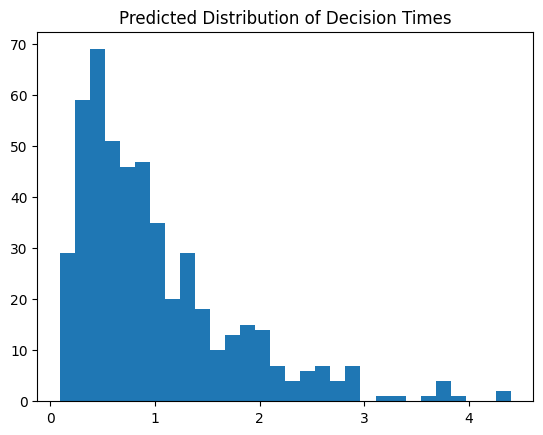

In [47]:
plt.hist(decisionTime,30);
plt.title('Predicted Distribution of Decision Times')
plt.show()

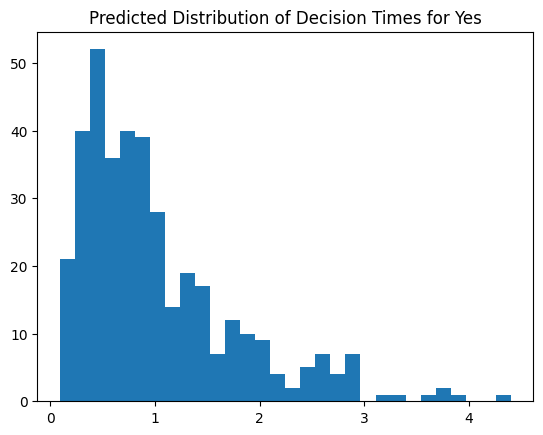

In [44]:
decisionTime_yes = [x for x, y in zip(decisionTime, choice) if y == True]

plt.hist(decisionTime_yes,30)
plt.title('Predicted Distribution of Decision Times for Yes')
plt.show()

## calculate choice proportions

In [50]:
prRs = (np.exp(2*delta*alpha/sigma**2) - np.exp(2*delta*(alpha-z)/sigma**2))/(np.exp(2*delta*alpha/sigma**2)-1)

print("Predicted Prob of Hitting Upper Boundary", prRs)

Predicted Prob of Hitting Upper Boundary 0.731058578630005


In [51]:
prRn = (np.exp(-2*delta*alpha/sigma**2) - np.exp(-2*delta*z/sigma**2))/(np.exp(-2*delta*alpha/sigma**2)-1)
       
print("Predicted Prob of Hitting Lower Boundary", prRn)


Predicted Prob of Hitting Lower Boundary 0.2689414213699951


## calculate response times

In [52]:
m_s = 2*delta/(sigma**2)
m_n = -2*delta/(sigma**2)
outside = 1/delta;
inside1 = (alpha*np.exp(z*m_s)+alpha*np.exp(-(alpha-z)*m_s))/(np.exp(z*m_s)-np.exp(-(alpha-z)*m_s))
inside2 = (z*np.exp(z*m_s)+z)/(np.exp(z*m_s)-1)
ETRs = outside*(inside1 - inside2)
print("Predicted Time to hit upper boundary", ETRs)

Predicted Time to hit upper boundary 0.9242343145200191


In [53]:
outside = 1/delta;
inside1 = (alpha*np.exp(z*m_s)+alpha*np.exp(-(alpha-z)*m_s))/(np.exp(z*m_s)-np.exp(-(alpha-z)*m_s))
inside2 = ((alpha-z)*np.exp(-(alpha-z)*m_s)+(alpha-z))/(np.exp(-(alpha-z)*m_s)-1)
ETRn = outside*(inside1 + inside2)
print('Predicted Time to hit lower boundary ', ETRn)

Predicted Time to hit lower boundary  0.9242343145200191


## Code up the joint cumulative probability distribution for obtaining a choice response less than T and responding shoot.


In [54]:
t =.1  # need a specific time
# do this thing in parts
A = np.pi*sigma**2/alpha**2
B = np.exp(delta*(alpha-z)/sigma**2)
k = 0
S = 0
mem1 = 1
mem2 = 1
tol = 10e-29
k = 1;

while (abs(mem1) > abs(S *tol) or abs(mem2) > abs(S*tol)):
    #using tolerance method from Ratcliff & Tuerlinckx, 2002, p. 478
    C = 2*k*np.sin(k*np.pi*(alpha-z)/alpha)
    inside = (-delta)**2/sigma**2 + np.pi**2*k**2*sigma**2/alpha**2
    D = np.exp(-.5*inside*t)
    term = C*D/inside
    mem2 = mem1
    mem1 = term
    S = S+ term
    k = k+1

In [55]:
CDF_RS = prRs - A*B*S
CDF_RS

0.002553308778219354

## Code up the joint cumulative probability distribution for obtaining a choice response less than T and responding no.


In [56]:
t =10 # need a specific time
# do this thing in parts
A = np.pi*sigma**2/alpha**2
B = np.exp(-delta*(z)/sigma**2)
k = 0
S = 0
mem1 = 1
mem2 = 1
tol = 10e-29
k = 1
while ( abs(mem1) > abs(S*tol) or abs(mem2) > abs(S*tol)):
    # using tolerance method from Ratcliff & Tuerlinckx, 2002, p. 478
    C = 2*k*np.sin(k*np.pi*(z)/alpha)
    inside = (delta)**2/sigma**2 + np.pi**2*k**2*sigma**2/alpha**2
    D = np.exp(-.5*inside*t)
    term = C*D/inside
    mem2 = mem1
    mem1 = term
    S = S+ term
    k = k+1

In [57]:
CDF_RN = prRn - A*B*S
CDF_RN 

0.26894098075692635

## plot the cdf for shoot and don't shoot


In [ ]:
def cumcdfDDM(t, delta, alpha, z, sigma, top):
    